# Time series classification with Tensorflow & Keras using <font color= #70e514>CNN / ConvNets</font>

## We will use :  <font color=red>Module: $tf.layers$</font>

- ## This library provides a set of high-level neural networks layers.

## You could also review: <font color=red>Module: $tf.keras$</font>

- ## Implementation of the Keras API meant to be a high-level API for TensorFlow.

* <font size=5 color='green'>[MSTC](http://mstc.ssr.upm.es/big-data-track) seminar on Deep Learning, Tensorflow & Keras</font>


## $HAR$ : Humman Activity Recognition

## Example form:

## Time series classification with Tensorflow burakhimmetogluAugust 22, 2017
(https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/)

<img src=https://burakhimmetoglu.files.wordpress.com/2017/08/ekg-158177_640.png height="200" width="260">

## See Notebooks in GitHub [healthDataScience](https://github.com/healthDataScience)  : $deep-learning-HAR$


![healthDataScience](https://avatars2.githubusercontent.com/u/30838413?s=200&v=4)

In [154]:
! pip install --upgrade tqdm

try:
    from tqdm import tqdm, tqdm_notebook
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages


In [0]:
# Imports
import numpy as np
import os

import tensorflow as tf
import math


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline



## Some UTILITY functions

In [0]:

import pandas as pd 
import numpy as np
import os


def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y


def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]
	


# Human Activity Recognition (HAR) Dataset
## From: [UCI Repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)



## Reading data already prepared from orignal UCI Dataset from a Shared Google Drive npz file

In [100]:
! pip install googledrivedownloader

In [119]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VLgB0CK8DjMJ4gstLRC0gA2pVGXy-RYa',
                                    dest_path='./UCI_HAR_Dataset_Drive.npz',
                                    unzip=False)

In [157]:
npzfile = np.load('UCI_HAR_Dataset_Drive.npz')
npzfile.files

X_train=npzfile['arr_0']
X_test=npzfile['arr_1']
labels_train=npzfile['arr_2']
labels_test=npzfile['arr_3']

print('Training data size: ',X_train.shape)
print('Test data size: ',X_test.shape)

print('Training labels size: ',labels_train.shape)
print('Test labels size: ',labels_test.shape)

Training data size:  (7352, 128, 9)
Test data size:  (2947, 128, 9)
Training labels size:  (7352,)
Test labels size:  (2947,)


## Six categories (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING).

[LSTM-Human-Activity-Recognition](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)

    The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.

## ... see some labels...

WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

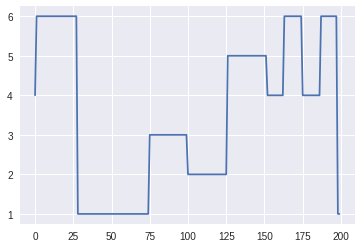

In [158]:
plt.plot(labels_train[50:250])

## ...see some signals...

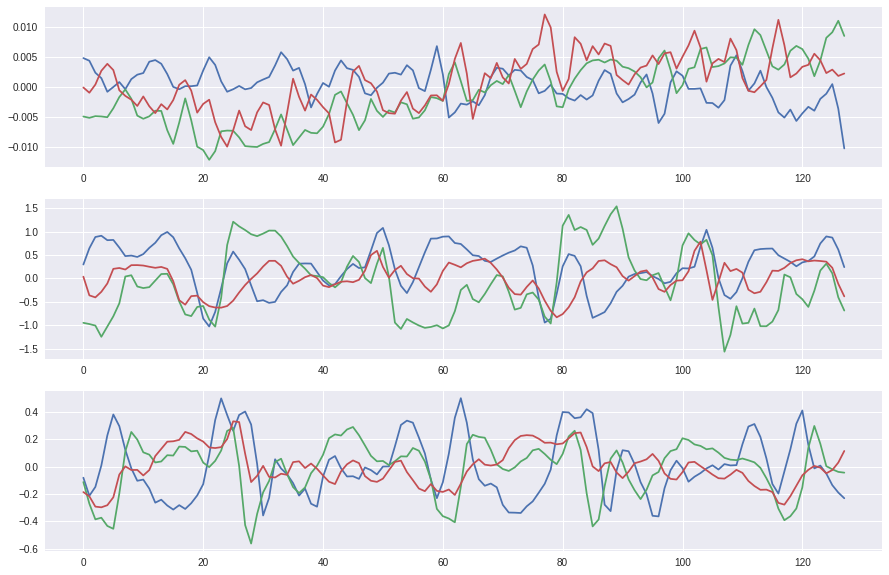

In [153]:
plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
plt.subplot(3,1,1)
plt.plot(X_train[50,:,0])
plt.plot(X_train[50,:,1])
plt.plot(X_train[50,:,2])

plt.subplot(3,1,2)
plt.plot(X_train[80,:,3])
plt.plot(X_train[80,:,4])
plt.plot(X_train[80,:,5])

plt.subplot(3,1,3)
plt.plot(X_train[110,:,0])
plt.plot(X_train[110,:,1])
plt.plot(X_train[110,:,2])

## One-hot-encoding of Labels

In [0]:
y_train = one_hot(labels_train)
y_test = one_hot(labels_test)


## Construct the graph

- Placeholders


In [0]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

- Build Convolutional Layers

In [165]:
# (batch, 128, 9) --> (batch, 64, 18)
conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
# (batch, 64, 18) --> (batch, 32, 36)
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')

# (batch, 32, 36) --> (batch, 16, 72)
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
# (batch, 16, 72) --> (batch, 8, 144)
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


- Flatten and pass to the classifier

In [0]:
# Flatten and add dropout
flat = tf.reshape(max_pool_4, (-1, 8*144))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
# Predictions
logits = tf.layers.dense(flat, n_classes)
    
# Cost function and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels_))
optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train the network

In [168]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_test, y_test, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1

Epoch: 0/1000 Iteration: 5 Train loss: 1.797730 Train acc: 0.185000
Epoch: 0/1000 Iteration: 10 Train loss: 1.788988 Train acc: 0.186667
Epoch: 0/1000 Iteration: 10 Validation loss: 1.769959 Validation acc: 0.172083
Epoch: 1/1000 Iteration: 15 Train loss: 1.745939 Train acc: 0.198333
Epoch: 1/1000 Iteration: 20 Train loss: 1.746376 Train acc: 0.161667
Epoch: 1/1000 Iteration: 20 Validation loss: 1.732166 Validation acc: 0.172917
Epoch: 2/1000 Iteration: 25 Train loss: 1.706790 Train acc: 0.220000
Epoch: 2/1000 Iteration: 30 Train loss: 1.714625 Train acc: 0.171667
Epoch: 2/1000 Iteration: 30 Validation loss: 1.699097 Validation acc: 0.172917
Epoch: 2/1000 Iteration: 35 Train loss: 1.708793 Train acc: 0.175000
Epoch: 3/1000 Iteration: 40 Train loss: 1.652085 Train acc: 0.250000
Epoch: 3/1000 Iteration: 40 Validation loss: 1.667780 Validation acc: 0.172917
Epoch: 3/1000 Iteration: 45 Train loss: 1.647627 Train acc: 0.233333
Epoch: 4/1000 Iteration: 50 Train loss: 1.616956 Train acc: 0.25

Epoch: 17/1000 Iteration: 215 Train loss: 0.861684 Train acc: 0.660000
Epoch: 18/1000 Iteration: 220 Train loss: 0.732417 Train acc: 0.706667
Epoch: 18/1000 Iteration: 220 Validation loss: 0.815616 Validation acc: 0.720833
Epoch: 18/1000 Iteration: 225 Train loss: 0.776098 Train acc: 0.710000
Epoch: 19/1000 Iteration: 230 Train loss: 0.783378 Train acc: 0.686667
Epoch: 19/1000 Iteration: 230 Validation loss: 0.792493 Validation acc: 0.732500
Epoch: 19/1000 Iteration: 235 Train loss: 0.711895 Train acc: 0.705000
Epoch: 19/1000 Iteration: 240 Train loss: 0.669549 Train acc: 0.731667
Epoch: 19/1000 Iteration: 240 Validation loss: 0.771464 Validation acc: 0.735000
Epoch: 20/1000 Iteration: 245 Train loss: 0.678796 Train acc: 0.735000
Epoch: 20/1000 Iteration: 250 Train loss: 0.652427 Train acc: 0.780000
Epoch: 20/1000 Iteration: 250 Validation loss: 0.753797 Validation acc: 0.727500
Epoch: 21/1000 Iteration: 255 Train loss: 0.653025 Train acc: 0.745000
Epoch: 21/1000 Iteration: 260 Train l

Epoch: 35/1000 Iteration: 425 Train loss: 0.466187 Train acc: 0.833333
Epoch: 35/1000 Iteration: 430 Train loss: 0.351890 Train acc: 0.888333
Epoch: 35/1000 Iteration: 430 Validation loss: 0.558452 Validation acc: 0.787500
Epoch: 36/1000 Iteration: 435 Train loss: 0.410783 Train acc: 0.866667
Epoch: 36/1000 Iteration: 440 Train loss: 0.270125 Train acc: 0.888333
Epoch: 36/1000 Iteration: 440 Validation loss: 0.550356 Validation acc: 0.793750
Epoch: 37/1000 Iteration: 445 Train loss: 0.316055 Train acc: 0.921667
Epoch: 37/1000 Iteration: 450 Train loss: 0.649117 Train acc: 0.693333
Epoch: 37/1000 Iteration: 450 Validation loss: 0.543338 Validation acc: 0.799583
Epoch: 37/1000 Iteration: 455 Train loss: 0.485174 Train acc: 0.876667
Epoch: 38/1000 Iteration: 460 Train loss: 0.419964 Train acc: 0.828333
Epoch: 38/1000 Iteration: 460 Validation loss: 0.537532 Validation acc: 0.801250
Epoch: 38/1000 Iteration: 465 Train loss: 0.364243 Train acc: 0.900000
Epoch: 39/1000 Iteration: 470 Train l

Epoch: 52/1000 Iteration: 635 Train loss: 0.391388 Train acc: 0.906667
Epoch: 53/1000 Iteration: 640 Train loss: 0.301723 Train acc: 0.888333
Epoch: 53/1000 Iteration: 640 Validation loss: 0.463374 Validation acc: 0.837083
Epoch: 53/1000 Iteration: 645 Train loss: 0.247046 Train acc: 0.941667
Epoch: 54/1000 Iteration: 650 Train loss: 0.325707 Train acc: 0.856667
Epoch: 54/1000 Iteration: 650 Validation loss: 0.460371 Validation acc: 0.835833
Epoch: 54/1000 Iteration: 655 Train loss: 0.265374 Train acc: 0.863333
Epoch: 54/1000 Iteration: 660 Train loss: 0.321844 Train acc: 0.876667
Epoch: 54/1000 Iteration: 660 Validation loss: 0.459291 Validation acc: 0.833333
Epoch: 55/1000 Iteration: 665 Train loss: 0.331821 Train acc: 0.880000
Epoch: 55/1000 Iteration: 670 Train loss: 0.207802 Train acc: 0.940000
Epoch: 55/1000 Iteration: 670 Validation loss: 0.457164 Validation acc: 0.832083
Epoch: 56/1000 Iteration: 675 Train loss: 0.262211 Train acc: 0.933333
Epoch: 56/1000 Iteration: 680 Train l

Epoch: 70/1000 Iteration: 845 Train loss: 0.259873 Train acc: 0.913333
Epoch: 70/1000 Iteration: 850 Train loss: 0.160185 Train acc: 0.965000
Epoch: 70/1000 Iteration: 850 Validation loss: 0.417024 Validation acc: 0.849583
Epoch: 71/1000 Iteration: 855 Train loss: 0.213297 Train acc: 0.933333
Epoch: 71/1000 Iteration: 860 Train loss: 0.145931 Train acc: 0.945000
Epoch: 71/1000 Iteration: 860 Validation loss: 0.415549 Validation acc: 0.850000
Epoch: 72/1000 Iteration: 865 Train loss: 0.155797 Train acc: 0.966667
Epoch: 72/1000 Iteration: 870 Train loss: 0.552028 Train acc: 0.728333
Epoch: 72/1000 Iteration: 870 Validation loss: 0.410944 Validation acc: 0.860417
Epoch: 72/1000 Iteration: 875 Train loss: 0.333107 Train acc: 0.925000
Epoch: 73/1000 Iteration: 880 Train loss: 0.210356 Train acc: 0.928333
Epoch: 73/1000 Iteration: 880 Validation loss: 0.408259 Validation acc: 0.862083
Epoch: 73/1000 Iteration: 885 Train loss: 0.185388 Train acc: 0.953333
Epoch: 74/1000 Iteration: 890 Train l

Epoch: 87/1000 Iteration: 1055 Train loss: 0.284730 Train acc: 0.935000
Epoch: 88/1000 Iteration: 1060 Train loss: 0.172330 Train acc: 0.930000
Epoch: 88/1000 Iteration: 1060 Validation loss: 0.382271 Validation acc: 0.871250
Epoch: 88/1000 Iteration: 1065 Train loss: 0.151785 Train acc: 0.961667
Epoch: 89/1000 Iteration: 1070 Train loss: 0.216483 Train acc: 0.901667
Epoch: 89/1000 Iteration: 1070 Validation loss: 0.379545 Validation acc: 0.870417
Epoch: 89/1000 Iteration: 1075 Train loss: 0.140789 Train acc: 0.933333
Epoch: 89/1000 Iteration: 1080 Train loss: 0.230122 Train acc: 0.901667
Epoch: 89/1000 Iteration: 1080 Validation loss: 0.378594 Validation acc: 0.865417
Epoch: 90/1000 Iteration: 1085 Train loss: 0.196858 Train acc: 0.930000
Epoch: 90/1000 Iteration: 1090 Train loss: 0.114325 Train acc: 0.985000
Epoch: 90/1000 Iteration: 1090 Validation loss: 0.378886 Validation acc: 0.865000
Epoch: 91/1000 Iteration: 1095 Train loss: 0.188436 Train acc: 0.943333
Epoch: 91/1000 Iteration

Epoch: 104/1000 Iteration: 1260 Train loss: 0.216044 Train acc: 0.905000
Epoch: 104/1000 Iteration: 1260 Validation loss: 0.358005 Validation acc: 0.870833
Epoch: 105/1000 Iteration: 1265 Train loss: 0.179431 Train acc: 0.928333
Epoch: 105/1000 Iteration: 1270 Train loss: 0.093917 Train acc: 0.988333
Epoch: 105/1000 Iteration: 1270 Validation loss: 0.357095 Validation acc: 0.871250
Epoch: 106/1000 Iteration: 1275 Train loss: 0.178051 Train acc: 0.940000
Epoch: 106/1000 Iteration: 1280 Train loss: 0.097200 Train acc: 0.955000
Epoch: 106/1000 Iteration: 1280 Validation loss: 0.356146 Validation acc: 0.871667
Epoch: 107/1000 Iteration: 1285 Train loss: 0.087617 Train acc: 0.983333
Epoch: 107/1000 Iteration: 1290 Train loss: 0.479561 Train acc: 0.765000
Epoch: 107/1000 Iteration: 1290 Validation loss: 0.355166 Validation acc: 0.874583
Epoch: 107/1000 Iteration: 1295 Train loss: 0.285901 Train acc: 0.923333
Epoch: 108/1000 Iteration: 1300 Train loss: 0.142319 Train acc: 0.958333
Epoch: 108/

Epoch: 122/1000 Iteration: 1465 Train loss: 0.081756 Train acc: 0.983333
Epoch: 122/1000 Iteration: 1470 Train loss: 0.448777 Train acc: 0.786667
Epoch: 122/1000 Iteration: 1470 Validation loss: 0.336827 Validation acc: 0.884583
Epoch: 122/1000 Iteration: 1475 Train loss: 0.260757 Train acc: 0.931667
Epoch: 123/1000 Iteration: 1480 Train loss: 0.111024 Train acc: 0.963333
Epoch: 123/1000 Iteration: 1480 Validation loss: 0.335296 Validation acc: 0.883333
Epoch: 123/1000 Iteration: 1485 Train loss: 0.115549 Train acc: 0.981667
Epoch: 124/1000 Iteration: 1490 Train loss: 0.183243 Train acc: 0.905000
Epoch: 124/1000 Iteration: 1490 Validation loss: 0.333331 Validation acc: 0.882500
Epoch: 124/1000 Iteration: 1495 Train loss: 0.106144 Train acc: 0.943333
Epoch: 124/1000 Iteration: 1500 Train loss: 0.200597 Train acc: 0.903333
Epoch: 124/1000 Iteration: 1500 Validation loss: 0.332758 Validation acc: 0.880000
Epoch: 125/1000 Iteration: 1505 Train loss: 0.148905 Train acc: 0.945000
Epoch: 125/

Epoch: 139/1000 Iteration: 1670 Train loss: 0.167818 Train acc: 0.915000
Epoch: 139/1000 Iteration: 1670 Validation loss: 0.320500 Validation acc: 0.884167
Epoch: 139/1000 Iteration: 1675 Train loss: 0.101520 Train acc: 0.953333
Epoch: 139/1000 Iteration: 1680 Train loss: 0.185077 Train acc: 0.911667
Epoch: 139/1000 Iteration: 1680 Validation loss: 0.319010 Validation acc: 0.883333
Epoch: 140/1000 Iteration: 1685 Train loss: 0.148422 Train acc: 0.946667
Epoch: 140/1000 Iteration: 1690 Train loss: 0.079357 Train acc: 0.988333
Epoch: 140/1000 Iteration: 1690 Validation loss: 0.319088 Validation acc: 0.883333
Epoch: 141/1000 Iteration: 1695 Train loss: 0.157868 Train acc: 0.945000
Epoch: 141/1000 Iteration: 1700 Train loss: 0.087395 Train acc: 0.956667
Epoch: 141/1000 Iteration: 1700 Validation loss: 0.319191 Validation acc: 0.884583
Epoch: 142/1000 Iteration: 1705 Train loss: 0.065141 Train acc: 0.995000
Epoch: 142/1000 Iteration: 1710 Train loss: 0.406831 Train acc: 0.791667
Epoch: 142/

Epoch: 156/1000 Iteration: 1875 Train loss: 0.146169 Train acc: 0.951667
Epoch: 156/1000 Iteration: 1880 Train loss: 0.082655 Train acc: 0.961667
Epoch: 156/1000 Iteration: 1880 Validation loss: 0.307431 Validation acc: 0.887500
Epoch: 157/1000 Iteration: 1885 Train loss: 0.066992 Train acc: 0.986667
Epoch: 157/1000 Iteration: 1890 Train loss: 0.380295 Train acc: 0.803333
Epoch: 157/1000 Iteration: 1890 Validation loss: 0.308226 Validation acc: 0.889167
Epoch: 157/1000 Iteration: 1895 Train loss: 0.245085 Train acc: 0.931667
Epoch: 158/1000 Iteration: 1900 Train loss: 0.092569 Train acc: 0.978333
Epoch: 158/1000 Iteration: 1900 Validation loss: 0.307983 Validation acc: 0.889167
Epoch: 158/1000 Iteration: 1905 Train loss: 0.093313 Train acc: 0.991667
Epoch: 159/1000 Iteration: 1910 Train loss: 0.168459 Train acc: 0.908333
Epoch: 159/1000 Iteration: 1910 Validation loss: 0.307590 Validation acc: 0.888750
Epoch: 159/1000 Iteration: 1915 Train loss: 0.085268 Train acc: 0.963333
Epoch: 159/

Epoch: 173/1000 Iteration: 2080 Train loss: 0.082042 Train acc: 0.981667
Epoch: 173/1000 Iteration: 2080 Validation loss: 0.301465 Validation acc: 0.890833
Epoch: 173/1000 Iteration: 2085 Train loss: 0.085681 Train acc: 0.996667
Epoch: 174/1000 Iteration: 2090 Train loss: 0.160103 Train acc: 0.918333
Epoch: 174/1000 Iteration: 2090 Validation loss: 0.300223 Validation acc: 0.889167
Epoch: 174/1000 Iteration: 2095 Train loss: 0.088291 Train acc: 0.955000
Epoch: 174/1000 Iteration: 2100 Train loss: 0.178515 Train acc: 0.908333
Epoch: 174/1000 Iteration: 2100 Validation loss: 0.299050 Validation acc: 0.886250
Epoch: 175/1000 Iteration: 2105 Train loss: 0.115479 Train acc: 0.946667
Epoch: 175/1000 Iteration: 2110 Train loss: 0.066179 Train acc: 0.995000
Epoch: 175/1000 Iteration: 2110 Validation loss: 0.298945 Validation acc: 0.884583
Epoch: 176/1000 Iteration: 2115 Train loss: 0.139134 Train acc: 0.950000
Epoch: 176/1000 Iteration: 2120 Train loss: 0.083225 Train acc: 0.960000
Epoch: 176/

Epoch: 190/1000 Iteration: 2285 Train loss: 0.114615 Train acc: 0.953333
Epoch: 190/1000 Iteration: 2290 Train loss: 0.061526 Train acc: 0.996667
Epoch: 190/1000 Iteration: 2290 Validation loss: 0.293465 Validation acc: 0.887917
Epoch: 191/1000 Iteration: 2295 Train loss: 0.149523 Train acc: 0.940000
Epoch: 191/1000 Iteration: 2300 Train loss: 0.081624 Train acc: 0.960000
Epoch: 191/1000 Iteration: 2300 Validation loss: 0.293075 Validation acc: 0.888333
Epoch: 192/1000 Iteration: 2305 Train loss: 0.051963 Train acc: 0.988333
Epoch: 192/1000 Iteration: 2310 Train loss: 0.347848 Train acc: 0.810000
Epoch: 192/1000 Iteration: 2310 Validation loss: 0.294007 Validation acc: 0.890000
Epoch: 192/1000 Iteration: 2315 Train loss: 0.242391 Train acc: 0.936667
Epoch: 193/1000 Iteration: 2320 Train loss: 0.066944 Train acc: 0.985000
Epoch: 193/1000 Iteration: 2320 Validation loss: 0.294124 Validation acc: 0.892083
Epoch: 193/1000 Iteration: 2325 Train loss: 0.083160 Train acc: 0.996667
Epoch: 194/

Epoch: 207/1000 Iteration: 2490 Train loss: 0.334190 Train acc: 0.830000
Epoch: 207/1000 Iteration: 2490 Validation loss: 0.291480 Validation acc: 0.892083
Epoch: 207/1000 Iteration: 2495 Train loss: 0.232634 Train acc: 0.935000
Epoch: 208/1000 Iteration: 2500 Train loss: 0.069603 Train acc: 0.978333
Epoch: 208/1000 Iteration: 2500 Validation loss: 0.292368 Validation acc: 0.892083
Epoch: 208/1000 Iteration: 2505 Train loss: 0.083653 Train acc: 0.990000
Epoch: 209/1000 Iteration: 2510 Train loss: 0.151782 Train acc: 0.910000
Epoch: 209/1000 Iteration: 2510 Validation loss: 0.290212 Validation acc: 0.887917
Epoch: 209/1000 Iteration: 2515 Train loss: 0.079668 Train acc: 0.960000
Epoch: 209/1000 Iteration: 2520 Train loss: 0.176135 Train acc: 0.913333
Epoch: 209/1000 Iteration: 2520 Validation loss: 0.289205 Validation acc: 0.886667
Epoch: 210/1000 Iteration: 2525 Train loss: 0.103523 Train acc: 0.966667
Epoch: 210/1000 Iteration: 2530 Train loss: 0.057192 Train acc: 0.996667
Epoch: 210/

Epoch: 224/1000 Iteration: 2695 Train loss: 0.079840 Train acc: 0.955000
Epoch: 224/1000 Iteration: 2700 Train loss: 0.168357 Train acc: 0.916667
Epoch: 224/1000 Iteration: 2700 Validation loss: 0.287370 Validation acc: 0.887917
Epoch: 225/1000 Iteration: 2705 Train loss: 0.095728 Train acc: 0.960000
Epoch: 225/1000 Iteration: 2710 Train loss: 0.054279 Train acc: 0.996667
Epoch: 225/1000 Iteration: 2710 Validation loss: 0.288119 Validation acc: 0.888750
Epoch: 226/1000 Iteration: 2715 Train loss: 0.134301 Train acc: 0.955000
Epoch: 226/1000 Iteration: 2720 Train loss: 0.072370 Train acc: 0.963333
Epoch: 226/1000 Iteration: 2720 Validation loss: 0.287717 Validation acc: 0.890833
Epoch: 227/1000 Iteration: 2725 Train loss: 0.038322 Train acc: 0.996667
Epoch: 227/1000 Iteration: 2730 Train loss: 0.321424 Train acc: 0.831667
Epoch: 227/1000 Iteration: 2730 Validation loss: 0.288195 Validation acc: 0.892500
Epoch: 227/1000 Iteration: 2735 Train loss: 0.224621 Train acc: 0.936667
Epoch: 228/

Epoch: 241/1000 Iteration: 2900 Train loss: 0.073277 Train acc: 0.963333
Epoch: 241/1000 Iteration: 2900 Validation loss: 0.285345 Validation acc: 0.890417
Epoch: 242/1000 Iteration: 2905 Train loss: 0.036748 Train acc: 0.998333
Epoch: 242/1000 Iteration: 2910 Train loss: 0.320073 Train acc: 0.830000
Epoch: 242/1000 Iteration: 2910 Validation loss: 0.287809 Validation acc: 0.892083
Epoch: 242/1000 Iteration: 2915 Train loss: 0.225123 Train acc: 0.936667
Epoch: 243/1000 Iteration: 2920 Train loss: 0.062728 Train acc: 0.981667
Epoch: 243/1000 Iteration: 2920 Validation loss: 0.286718 Validation acc: 0.892500
Epoch: 243/1000 Iteration: 2925 Train loss: 0.076744 Train acc: 0.988333
Epoch: 244/1000 Iteration: 2930 Train loss: 0.150550 Train acc: 0.913333
Epoch: 244/1000 Iteration: 2930 Validation loss: 0.285449 Validation acc: 0.890833
Epoch: 244/1000 Iteration: 2935 Train loss: 0.070046 Train acc: 0.970000
Epoch: 244/1000 Iteration: 2940 Train loss: 0.160858 Train acc: 0.926667
Epoch: 244/

Epoch: 258/1000 Iteration: 3105 Train loss: 0.072732 Train acc: 0.991667
Epoch: 259/1000 Iteration: 3110 Train loss: 0.140793 Train acc: 0.913333
Epoch: 259/1000 Iteration: 3110 Validation loss: 0.284281 Validation acc: 0.891250
Epoch: 259/1000 Iteration: 3115 Train loss: 0.068884 Train acc: 0.968333
Epoch: 259/1000 Iteration: 3120 Train loss: 0.159652 Train acc: 0.931667
Epoch: 259/1000 Iteration: 3120 Validation loss: 0.281706 Validation acc: 0.890000
Epoch: 260/1000 Iteration: 3125 Train loss: 0.091081 Train acc: 0.961667
Epoch: 260/1000 Iteration: 3130 Train loss: 0.050100 Train acc: 0.998333
Epoch: 260/1000 Iteration: 3130 Validation loss: 0.282913 Validation acc: 0.892083
Epoch: 261/1000 Iteration: 3135 Train loss: 0.131344 Train acc: 0.945000
Epoch: 261/1000 Iteration: 3140 Train loss: 0.072410 Train acc: 0.961667
Epoch: 261/1000 Iteration: 3140 Validation loss: 0.282396 Validation acc: 0.892500
Epoch: 262/1000 Iteration: 3145 Train loss: 0.030241 Train acc: 0.998333
Epoch: 262/

Epoch: 275/1000 Iteration: 3310 Train loss: 0.044713 Train acc: 1.000000
Epoch: 275/1000 Iteration: 3310 Validation loss: 0.280458 Validation acc: 0.892917
Epoch: 276/1000 Iteration: 3315 Train loss: 0.131416 Train acc: 0.943333
Epoch: 276/1000 Iteration: 3320 Train loss: 0.075033 Train acc: 0.958333
Epoch: 276/1000 Iteration: 3320 Validation loss: 0.280541 Validation acc: 0.893333
Epoch: 277/1000 Iteration: 3325 Train loss: 0.032680 Train acc: 0.996667
Epoch: 277/1000 Iteration: 3330 Train loss: 0.296990 Train acc: 0.836667
Epoch: 277/1000 Iteration: 3330 Validation loss: 0.283167 Validation acc: 0.892083
Epoch: 277/1000 Iteration: 3335 Train loss: 0.230005 Train acc: 0.936667
Epoch: 278/1000 Iteration: 3340 Train loss: 0.055734 Train acc: 0.986667
Epoch: 278/1000 Iteration: 3340 Validation loss: 0.282927 Validation acc: 0.894583
Epoch: 278/1000 Iteration: 3345 Train loss: 0.071863 Train acc: 0.995000
Epoch: 279/1000 Iteration: 3350 Train loss: 0.143219 Train acc: 0.923333
Epoch: 279/

Epoch: 292/1000 Iteration: 3515 Train loss: 0.213459 Train acc: 0.935000
Epoch: 293/1000 Iteration: 3520 Train loss: 0.053608 Train acc: 0.985000
Epoch: 293/1000 Iteration: 3520 Validation loss: 0.279934 Validation acc: 0.895000
Epoch: 293/1000 Iteration: 3525 Train loss: 0.069441 Train acc: 0.991667
Epoch: 294/1000 Iteration: 3530 Train loss: 0.131630 Train acc: 0.923333
Epoch: 294/1000 Iteration: 3530 Validation loss: 0.278243 Validation acc: 0.896250
Epoch: 294/1000 Iteration: 3535 Train loss: 0.070456 Train acc: 0.963333
Epoch: 294/1000 Iteration: 3540 Train loss: 0.147434 Train acc: 0.930000
Epoch: 294/1000 Iteration: 3540 Validation loss: 0.280699 Validation acc: 0.891667
Epoch: 295/1000 Iteration: 3545 Train loss: 0.086362 Train acc: 0.966667
Epoch: 295/1000 Iteration: 3550 Train loss: 0.042763 Train acc: 0.998333
Epoch: 295/1000 Iteration: 3550 Validation loss: 0.278925 Validation acc: 0.893750
Epoch: 296/1000 Iteration: 3555 Train loss: 0.134557 Train acc: 0.938333
Epoch: 296/

Epoch: 309/1000 Iteration: 3720 Train loss: 0.149782 Train acc: 0.926667
Epoch: 309/1000 Iteration: 3720 Validation loss: 0.278580 Validation acc: 0.892917
Epoch: 310/1000 Iteration: 3725 Train loss: 0.079032 Train acc: 0.973333
Epoch: 310/1000 Iteration: 3730 Train loss: 0.041083 Train acc: 1.000000
Epoch: 310/1000 Iteration: 3730 Validation loss: 0.278707 Validation acc: 0.893333
Epoch: 311/1000 Iteration: 3735 Train loss: 0.130956 Train acc: 0.938333
Epoch: 311/1000 Iteration: 3740 Train loss: 0.075502 Train acc: 0.955000
Epoch: 311/1000 Iteration: 3740 Validation loss: 0.277785 Validation acc: 0.894583
Epoch: 312/1000 Iteration: 3745 Train loss: 0.028229 Train acc: 0.998333
Epoch: 312/1000 Iteration: 3750 Train loss: 0.277941 Train acc: 0.840000
Epoch: 312/1000 Iteration: 3750 Validation loss: 0.280034 Validation acc: 0.896250
Epoch: 312/1000 Iteration: 3755 Train loss: 0.212612 Train acc: 0.936667
Epoch: 313/1000 Iteration: 3760 Train loss: 0.045549 Train acc: 1.000000
Epoch: 313/

Epoch: 327/1000 Iteration: 3925 Train loss: 0.025904 Train acc: 0.996667
Epoch: 327/1000 Iteration: 3930 Train loss: 0.276780 Train acc: 0.845000
Epoch: 327/1000 Iteration: 3930 Validation loss: 0.279456 Validation acc: 0.896667
Epoch: 327/1000 Iteration: 3935 Train loss: 0.216420 Train acc: 0.936667
Epoch: 328/1000 Iteration: 3940 Train loss: 0.047677 Train acc: 0.986667
Epoch: 328/1000 Iteration: 3940 Validation loss: 0.281010 Validation acc: 0.895833
Epoch: 328/1000 Iteration: 3945 Train loss: 0.065685 Train acc: 0.991667
Epoch: 329/1000 Iteration: 3950 Train loss: 0.128941 Train acc: 0.923333
Epoch: 329/1000 Iteration: 3950 Validation loss: 0.278469 Validation acc: 0.895417
Epoch: 329/1000 Iteration: 3955 Train loss: 0.064060 Train acc: 0.968333
Epoch: 329/1000 Iteration: 3960 Train loss: 0.149388 Train acc: 0.925000
Epoch: 329/1000 Iteration: 3960 Validation loss: 0.275181 Validation acc: 0.895417
Epoch: 330/1000 Iteration: 3965 Train loss: 0.076902 Train acc: 0.978333
Epoch: 330/

Epoch: 344/1000 Iteration: 4130 Train loss: 0.133673 Train acc: 0.920000
Epoch: 344/1000 Iteration: 4130 Validation loss: 0.275277 Validation acc: 0.897083
Epoch: 344/1000 Iteration: 4135 Train loss: 0.061308 Train acc: 0.975000
Epoch: 344/1000 Iteration: 4140 Train loss: 0.139301 Train acc: 0.928333
Epoch: 344/1000 Iteration: 4140 Validation loss: 0.276859 Validation acc: 0.895833
Epoch: 345/1000 Iteration: 4145 Train loss: 0.078150 Train acc: 0.976667
Epoch: 345/1000 Iteration: 4150 Train loss: 0.037294 Train acc: 1.000000
Epoch: 345/1000 Iteration: 4150 Validation loss: 0.276130 Validation acc: 0.895417
Epoch: 346/1000 Iteration: 4155 Train loss: 0.128684 Train acc: 0.943333
Epoch: 346/1000 Iteration: 4160 Train loss: 0.073187 Train acc: 0.965000
Epoch: 346/1000 Iteration: 4160 Validation loss: 0.275262 Validation acc: 0.896667
Epoch: 347/1000 Iteration: 4165 Train loss: 0.023756 Train acc: 0.998333
Epoch: 347/1000 Iteration: 4170 Train loss: 0.272740 Train acc: 0.845000
Epoch: 347/

Epoch: 361/1000 Iteration: 4335 Train loss: 0.124379 Train acc: 0.950000
Epoch: 361/1000 Iteration: 4340 Train loss: 0.066714 Train acc: 0.965000
Epoch: 361/1000 Iteration: 4340 Validation loss: 0.277369 Validation acc: 0.895000
Epoch: 362/1000 Iteration: 4345 Train loss: 0.027036 Train acc: 0.995000
Epoch: 362/1000 Iteration: 4350 Train loss: 0.264841 Train acc: 0.845000
Epoch: 362/1000 Iteration: 4350 Validation loss: 0.278398 Validation acc: 0.897083
Epoch: 362/1000 Iteration: 4355 Train loss: 0.217625 Train acc: 0.936667
Epoch: 363/1000 Iteration: 4360 Train loss: 0.047088 Train acc: 0.995000
Epoch: 363/1000 Iteration: 4360 Validation loss: 0.278556 Validation acc: 0.897083
Epoch: 363/1000 Iteration: 4365 Train loss: 0.067643 Train acc: 0.995000
Epoch: 364/1000 Iteration: 4370 Train loss: 0.125398 Train acc: 0.926667
Epoch: 364/1000 Iteration: 4370 Validation loss: 0.277562 Validation acc: 0.897917
Epoch: 364/1000 Iteration: 4375 Train loss: 0.057954 Train acc: 0.975000
Epoch: 364/

Epoch: 378/1000 Iteration: 4540 Train loss: 0.046621 Train acc: 0.990000
Epoch: 378/1000 Iteration: 4540 Validation loss: 0.280236 Validation acc: 0.898750
Epoch: 378/1000 Iteration: 4545 Train loss: 0.072618 Train acc: 0.988333
Epoch: 379/1000 Iteration: 4550 Train loss: 0.122002 Train acc: 0.930000
Epoch: 379/1000 Iteration: 4550 Validation loss: 0.277110 Validation acc: 0.897500
Epoch: 379/1000 Iteration: 4555 Train loss: 0.060370 Train acc: 0.971667
Epoch: 379/1000 Iteration: 4560 Train loss: 0.136715 Train acc: 0.938333
Epoch: 379/1000 Iteration: 4560 Validation loss: 0.275066 Validation acc: 0.895833
Epoch: 380/1000 Iteration: 4565 Train loss: 0.074613 Train acc: 0.971667
Epoch: 380/1000 Iteration: 4570 Train loss: 0.033732 Train acc: 1.000000
Epoch: 380/1000 Iteration: 4570 Validation loss: 0.278452 Validation acc: 0.896667
Epoch: 381/1000 Iteration: 4575 Train loss: 0.133286 Train acc: 0.945000
Epoch: 381/1000 Iteration: 4580 Train loss: 0.071494 Train acc: 0.966667
Epoch: 381/

Epoch: 395/1000 Iteration: 4745 Train loss: 0.076536 Train acc: 0.973333
Epoch: 395/1000 Iteration: 4750 Train loss: 0.033473 Train acc: 1.000000
Epoch: 395/1000 Iteration: 4750 Validation loss: 0.277374 Validation acc: 0.895000
Epoch: 396/1000 Iteration: 4755 Train loss: 0.134048 Train acc: 0.923333
Epoch: 396/1000 Iteration: 4760 Train loss: 0.070427 Train acc: 0.968333
Epoch: 396/1000 Iteration: 4760 Validation loss: 0.274845 Validation acc: 0.898333
Epoch: 397/1000 Iteration: 4765 Train loss: 0.024785 Train acc: 0.996667
Epoch: 397/1000 Iteration: 4770 Train loss: 0.262551 Train acc: 0.843333
Epoch: 397/1000 Iteration: 4770 Validation loss: 0.275871 Validation acc: 0.900000
Epoch: 397/1000 Iteration: 4775 Train loss: 0.208315 Train acc: 0.936667
Epoch: 398/1000 Iteration: 4780 Train loss: 0.044795 Train acc: 0.993333
Epoch: 398/1000 Iteration: 4780 Validation loss: 0.277580 Validation acc: 0.899167
Epoch: 398/1000 Iteration: 4785 Train loss: 0.071982 Train acc: 0.988333
Epoch: 399/

Epoch: 412/1000 Iteration: 4950 Train loss: 0.246805 Train acc: 0.848333
Epoch: 412/1000 Iteration: 4950 Validation loss: 0.276215 Validation acc: 0.899167
Epoch: 412/1000 Iteration: 4955 Train loss: 0.213899 Train acc: 0.935000
Epoch: 413/1000 Iteration: 4960 Train loss: 0.046502 Train acc: 0.991667
Epoch: 413/1000 Iteration: 4960 Validation loss: 0.278798 Validation acc: 0.898750
Epoch: 413/1000 Iteration: 4965 Train loss: 0.074291 Train acc: 0.988333
Epoch: 414/1000 Iteration: 4970 Train loss: 0.121505 Train acc: 0.925000
Epoch: 414/1000 Iteration: 4970 Validation loss: 0.278060 Validation acc: 0.895000
Epoch: 414/1000 Iteration: 4975 Train loss: 0.055635 Train acc: 0.976667
Epoch: 414/1000 Iteration: 4980 Train loss: 0.129260 Train acc: 0.931667
Epoch: 414/1000 Iteration: 4980 Validation loss: 0.275466 Validation acc: 0.896667
Epoch: 415/1000 Iteration: 4985 Train loss: 0.073674 Train acc: 0.980000
Epoch: 415/1000 Iteration: 4990 Train loss: 0.031271 Train acc: 1.000000
Epoch: 415/

Epoch: 429/1000 Iteration: 5155 Train loss: 0.055123 Train acc: 0.975000
Epoch: 429/1000 Iteration: 5160 Train loss: 0.127671 Train acc: 0.935000
Epoch: 429/1000 Iteration: 5160 Validation loss: 0.275488 Validation acc: 0.897083
Epoch: 430/1000 Iteration: 5165 Train loss: 0.068777 Train acc: 0.978333
Epoch: 430/1000 Iteration: 5170 Train loss: 0.032297 Train acc: 0.998333
Epoch: 430/1000 Iteration: 5170 Validation loss: 0.273791 Validation acc: 0.899167
Epoch: 431/1000 Iteration: 5175 Train loss: 0.132573 Train acc: 0.936667
Epoch: 431/1000 Iteration: 5180 Train loss: 0.068749 Train acc: 0.976667
Epoch: 431/1000 Iteration: 5180 Validation loss: 0.274731 Validation acc: 0.897083
Epoch: 432/1000 Iteration: 5185 Train loss: 0.022478 Train acc: 0.996667
Epoch: 432/1000 Iteration: 5190 Train loss: 0.236395 Train acc: 0.853333
Epoch: 432/1000 Iteration: 5190 Validation loss: 0.274603 Validation acc: 0.900417
Epoch: 432/1000 Iteration: 5195 Train loss: 0.208227 Train acc: 0.936667
Epoch: 433/

Epoch: 446/1000 Iteration: 5360 Train loss: 0.068521 Train acc: 0.968333
Epoch: 446/1000 Iteration: 5360 Validation loss: 0.272727 Validation acc: 0.898750
Epoch: 447/1000 Iteration: 5365 Train loss: 0.023869 Train acc: 0.995000
Epoch: 447/1000 Iteration: 5370 Train loss: 0.240392 Train acc: 0.851667
Epoch: 447/1000 Iteration: 5370 Validation loss: 0.275744 Validation acc: 0.898750
Epoch: 447/1000 Iteration: 5375 Train loss: 0.204748 Train acc: 0.936667
Epoch: 448/1000 Iteration: 5380 Train loss: 0.044057 Train acc: 0.996667
Epoch: 448/1000 Iteration: 5380 Validation loss: 0.275768 Validation acc: 0.899583
Epoch: 448/1000 Iteration: 5385 Train loss: 0.076588 Train acc: 0.983333
Epoch: 449/1000 Iteration: 5390 Train loss: 0.123604 Train acc: 0.925000
Epoch: 449/1000 Iteration: 5390 Validation loss: 0.272304 Validation acc: 0.897917
Epoch: 449/1000 Iteration: 5395 Train loss: 0.055111 Train acc: 0.973333
Epoch: 449/1000 Iteration: 5400 Train loss: 0.116415 Train acc: 0.938333
Epoch: 449/

Epoch: 463/1000 Iteration: 5565 Train loss: 0.072652 Train acc: 0.981667
Epoch: 464/1000 Iteration: 5570 Train loss: 0.116128 Train acc: 0.933333
Epoch: 464/1000 Iteration: 5570 Validation loss: 0.274621 Validation acc: 0.896667
Epoch: 464/1000 Iteration: 5575 Train loss: 0.054780 Train acc: 0.971667
Epoch: 464/1000 Iteration: 5580 Train loss: 0.122768 Train acc: 0.935000
Epoch: 464/1000 Iteration: 5580 Validation loss: 0.268681 Validation acc: 0.899583
Epoch: 465/1000 Iteration: 5585 Train loss: 0.066467 Train acc: 0.985000
Epoch: 465/1000 Iteration: 5590 Train loss: 0.031451 Train acc: 1.000000
Epoch: 465/1000 Iteration: 5590 Validation loss: 0.271998 Validation acc: 0.897917
Epoch: 466/1000 Iteration: 5595 Train loss: 0.129739 Train acc: 0.930000
Epoch: 466/1000 Iteration: 5600 Train loss: 0.067981 Train acc: 0.966667
Epoch: 466/1000 Iteration: 5600 Validation loss: 0.273555 Validation acc: 0.898333
Epoch: 467/1000 Iteration: 5605 Train loss: 0.025032 Train acc: 0.998333
Epoch: 467/

Epoch: 480/1000 Iteration: 5770 Train loss: 0.030100 Train acc: 1.000000
Epoch: 480/1000 Iteration: 5770 Validation loss: 0.272588 Validation acc: 0.897917
Epoch: 481/1000 Iteration: 5775 Train loss: 0.129769 Train acc: 0.940000
Epoch: 481/1000 Iteration: 5780 Train loss: 0.063444 Train acc: 0.980000
Epoch: 481/1000 Iteration: 5780 Validation loss: 0.271386 Validation acc: 0.902500
Epoch: 482/1000 Iteration: 5785 Train loss: 0.022057 Train acc: 0.995000
Epoch: 482/1000 Iteration: 5790 Train loss: 0.229794 Train acc: 0.855000
Epoch: 482/1000 Iteration: 5790 Validation loss: 0.275133 Validation acc: 0.900417
Epoch: 482/1000 Iteration: 5795 Train loss: 0.199869 Train acc: 0.936667
Epoch: 483/1000 Iteration: 5800 Train loss: 0.038647 Train acc: 0.998333
Epoch: 483/1000 Iteration: 5800 Validation loss: 0.276373 Validation acc: 0.900000
Epoch: 483/1000 Iteration: 5805 Train loss: 0.071310 Train acc: 0.985000
Epoch: 484/1000 Iteration: 5810 Train loss: 0.113930 Train acc: 0.936667
Epoch: 484/

Epoch: 497/1000 Iteration: 5975 Train loss: 0.201245 Train acc: 0.936667
Epoch: 498/1000 Iteration: 5980 Train loss: 0.041873 Train acc: 0.991667
Epoch: 498/1000 Iteration: 5980 Validation loss: 0.273774 Validation acc: 0.900833
Epoch: 498/1000 Iteration: 5985 Train loss: 0.071338 Train acc: 0.980000
Epoch: 499/1000 Iteration: 5990 Train loss: 0.111109 Train acc: 0.933333
Epoch: 499/1000 Iteration: 5990 Validation loss: 0.270778 Validation acc: 0.901667
Epoch: 499/1000 Iteration: 5995 Train loss: 0.051509 Train acc: 0.976667
Epoch: 499/1000 Iteration: 6000 Train loss: 0.112056 Train acc: 0.946667
Epoch: 499/1000 Iteration: 6000 Validation loss: 0.273197 Validation acc: 0.900000
Epoch: 500/1000 Iteration: 6005 Train loss: 0.060396 Train acc: 0.986667
Epoch: 500/1000 Iteration: 6010 Train loss: 0.030243 Train acc: 1.000000
Epoch: 500/1000 Iteration: 6010 Validation loss: 0.272378 Validation acc: 0.899583
Epoch: 501/1000 Iteration: 6015 Train loss: 0.128317 Train acc: 0.943333
Epoch: 501/

Epoch: 514/1000 Iteration: 6180 Train loss: 0.114950 Train acc: 0.943333
Epoch: 514/1000 Iteration: 6180 Validation loss: 0.274898 Validation acc: 0.900833
Epoch: 515/1000 Iteration: 6185 Train loss: 0.065670 Train acc: 0.983333
Epoch: 515/1000 Iteration: 6190 Train loss: 0.029221 Train acc: 0.998333
Epoch: 515/1000 Iteration: 6190 Validation loss: 0.272827 Validation acc: 0.900833
Epoch: 516/1000 Iteration: 6195 Train loss: 0.128265 Train acc: 0.928333
Epoch: 516/1000 Iteration: 6200 Train loss: 0.063667 Train acc: 0.975000
Epoch: 516/1000 Iteration: 6200 Validation loss: 0.270527 Validation acc: 0.902917
Epoch: 517/1000 Iteration: 6205 Train loss: 0.022987 Train acc: 0.996667
Epoch: 517/1000 Iteration: 6210 Train loss: 0.231220 Train acc: 0.855000
Epoch: 517/1000 Iteration: 6210 Validation loss: 0.275358 Validation acc: 0.900833
Epoch: 517/1000 Iteration: 6215 Train loss: 0.198732 Train acc: 0.936667
Epoch: 518/1000 Iteration: 6220 Train loss: 0.043816 Train acc: 0.988333
Epoch: 518/

Epoch: 532/1000 Iteration: 6385 Train loss: 0.020307 Train acc: 0.998333
Epoch: 532/1000 Iteration: 6390 Train loss: 0.223323 Train acc: 0.856667
Epoch: 532/1000 Iteration: 6390 Validation loss: 0.266867 Validation acc: 0.903333
Epoch: 532/1000 Iteration: 6395 Train loss: 0.192305 Train acc: 0.936667
Epoch: 533/1000 Iteration: 6400 Train loss: 0.039078 Train acc: 0.995000
Epoch: 533/1000 Iteration: 6400 Validation loss: 0.268810 Validation acc: 0.901667
Epoch: 533/1000 Iteration: 6405 Train loss: 0.071260 Train acc: 0.976667
Epoch: 534/1000 Iteration: 6410 Train loss: 0.109595 Train acc: 0.935000
Epoch: 534/1000 Iteration: 6410 Validation loss: 0.272625 Validation acc: 0.902917
Epoch: 534/1000 Iteration: 6415 Train loss: 0.047948 Train acc: 0.985000
Epoch: 534/1000 Iteration: 6420 Train loss: 0.113088 Train acc: 0.941667
Epoch: 534/1000 Iteration: 6420 Validation loss: 0.270739 Validation acc: 0.902500
Epoch: 535/1000 Iteration: 6425 Train loss: 0.060424 Train acc: 0.985000
Epoch: 535/

Epoch: 549/1000 Iteration: 6590 Train loss: 0.111624 Train acc: 0.938333
Epoch: 549/1000 Iteration: 6590 Validation loss: 0.273079 Validation acc: 0.903333
Epoch: 549/1000 Iteration: 6595 Train loss: 0.049538 Train acc: 0.978333
Epoch: 549/1000 Iteration: 6600 Train loss: 0.115510 Train acc: 0.938333
Epoch: 549/1000 Iteration: 6600 Validation loss: 0.270815 Validation acc: 0.902917
Epoch: 550/1000 Iteration: 6605 Train loss: 0.059308 Train acc: 0.988333
Epoch: 550/1000 Iteration: 6610 Train loss: 0.026887 Train acc: 1.000000
Epoch: 550/1000 Iteration: 6610 Validation loss: 0.268070 Validation acc: 0.902917
Epoch: 551/1000 Iteration: 6615 Train loss: 0.130823 Train acc: 0.926667
Epoch: 551/1000 Iteration: 6620 Train loss: 0.062225 Train acc: 0.981667
Epoch: 551/1000 Iteration: 6620 Validation loss: 0.267686 Validation acc: 0.905000
Epoch: 552/1000 Iteration: 6625 Train loss: 0.021852 Train acc: 0.995000
Epoch: 552/1000 Iteration: 6630 Train loss: 0.223398 Train acc: 0.863333
Epoch: 552/

Epoch: 565/1000 Iteration: 6790 Train loss: 0.027161 Train acc: 1.000000
Epoch: 565/1000 Iteration: 6790 Validation loss: 0.270362 Validation acc: 0.903750
Epoch: 566/1000 Iteration: 6795 Train loss: 0.136767 Train acc: 0.921667
Epoch: 566/1000 Iteration: 6800 Train loss: 0.063954 Train acc: 0.986667
Epoch: 566/1000 Iteration: 6800 Validation loss: 0.268893 Validation acc: 0.905000
Epoch: 567/1000 Iteration: 6805 Train loss: 0.020181 Train acc: 0.998333
Epoch: 567/1000 Iteration: 6810 Train loss: 0.222164 Train acc: 0.856667
Epoch: 567/1000 Iteration: 6810 Validation loss: 0.272758 Validation acc: 0.902917
Epoch: 567/1000 Iteration: 6815 Train loss: 0.197993 Train acc: 0.938333
Epoch: 568/1000 Iteration: 6820 Train loss: 0.041317 Train acc: 0.995000
Epoch: 568/1000 Iteration: 6820 Validation loss: 0.272892 Validation acc: 0.903333
Epoch: 568/1000 Iteration: 6825 Train loss: 0.071262 Train acc: 0.980000
Epoch: 569/1000 Iteration: 6830 Train loss: 0.108957 Train acc: 0.940000
Epoch: 569/

Epoch: 582/1000 Iteration: 6990 Train loss: 0.221519 Train acc: 0.858333
Epoch: 582/1000 Iteration: 6990 Validation loss: 0.273674 Validation acc: 0.902917
Epoch: 582/1000 Iteration: 6995 Train loss: 0.193395 Train acc: 0.938333
Epoch: 583/1000 Iteration: 7000 Train loss: 0.035681 Train acc: 0.998333
Epoch: 583/1000 Iteration: 7000 Validation loss: 0.271977 Validation acc: 0.903333
Epoch: 583/1000 Iteration: 7005 Train loss: 0.073732 Train acc: 0.973333
Epoch: 584/1000 Iteration: 7010 Train loss: 0.103000 Train acc: 0.938333
Epoch: 584/1000 Iteration: 7010 Validation loss: 0.268474 Validation acc: 0.905000
Epoch: 584/1000 Iteration: 7015 Train loss: 0.047247 Train acc: 0.981667
Epoch: 584/1000 Iteration: 7020 Train loss: 0.105954 Train acc: 0.950000
Epoch: 584/1000 Iteration: 7020 Validation loss: 0.266724 Validation acc: 0.905833
Epoch: 585/1000 Iteration: 7025 Train loss: 0.057426 Train acc: 0.985000
Epoch: 585/1000 Iteration: 7030 Train loss: 0.025624 Train acc: 1.000000
Epoch: 585/

Epoch: 599/1000 Iteration: 7190 Train loss: 0.101315 Train acc: 0.936667
Epoch: 599/1000 Iteration: 7190 Validation loss: 0.272153 Validation acc: 0.904583
Epoch: 599/1000 Iteration: 7195 Train loss: 0.045836 Train acc: 0.983333
Epoch: 599/1000 Iteration: 7200 Train loss: 0.110064 Train acc: 0.948333
Epoch: 599/1000 Iteration: 7200 Validation loss: 0.271310 Validation acc: 0.906667
Epoch: 600/1000 Iteration: 7205 Train loss: 0.057112 Train acc: 0.985000
Epoch: 600/1000 Iteration: 7210 Train loss: 0.027024 Train acc: 1.000000
Epoch: 600/1000 Iteration: 7210 Validation loss: 0.271203 Validation acc: 0.905417
Epoch: 601/1000 Iteration: 7215 Train loss: 0.134443 Train acc: 0.923333
Epoch: 601/1000 Iteration: 7220 Train loss: 0.065360 Train acc: 0.980000
Epoch: 601/1000 Iteration: 7220 Validation loss: 0.269750 Validation acc: 0.904583
Epoch: 602/1000 Iteration: 7225 Train loss: 0.020161 Train acc: 0.996667
Epoch: 602/1000 Iteration: 7230 Train loss: 0.212667 Train acc: 0.871667
Epoch: 602/

Epoch: 614/1000 Iteration: 7370 Validation loss: 0.268884 Validation acc: 0.908333
Epoch: 614/1000 Iteration: 7375 Train loss: 0.046424 Train acc: 0.981667
Epoch: 614/1000 Iteration: 7380 Train loss: 0.099585 Train acc: 0.953333
Epoch: 614/1000 Iteration: 7380 Validation loss: 0.267830 Validation acc: 0.906250
Epoch: 615/1000 Iteration: 7385 Train loss: 0.054014 Train acc: 0.990000
Epoch: 615/1000 Iteration: 7390 Train loss: 0.024442 Train acc: 1.000000
Epoch: 615/1000 Iteration: 7390 Validation loss: 0.274510 Validation acc: 0.904583
Epoch: 616/1000 Iteration: 7395 Train loss: 0.125889 Train acc: 0.933333
Epoch: 616/1000 Iteration: 7400 Train loss: 0.063768 Train acc: 0.983333
Epoch: 616/1000 Iteration: 7400 Validation loss: 0.274648 Validation acc: 0.905833
Epoch: 617/1000 Iteration: 7405 Train loss: 0.021611 Train acc: 0.995000
Epoch: 617/1000 Iteration: 7410 Train loss: 0.208061 Train acc: 0.860000
Epoch: 617/1000 Iteration: 7410 Validation loss: 0.271252 Validation acc: 0.905833
E

Epoch: 629/1000 Iteration: 7560 Train loss: 0.103065 Train acc: 0.945000
Epoch: 629/1000 Iteration: 7560 Validation loss: 0.267835 Validation acc: 0.907083
Epoch: 630/1000 Iteration: 7565 Train loss: 0.052317 Train acc: 0.990000
Epoch: 630/1000 Iteration: 7570 Train loss: 0.025112 Train acc: 1.000000
Epoch: 630/1000 Iteration: 7570 Validation loss: 0.268410 Validation acc: 0.908333
Epoch: 631/1000 Iteration: 7575 Train loss: 0.127449 Train acc: 0.936667
Epoch: 631/1000 Iteration: 7580 Train loss: 0.062388 Train acc: 0.985000
Epoch: 631/1000 Iteration: 7580 Validation loss: 0.273302 Validation acc: 0.907500
Epoch: 632/1000 Iteration: 7585 Train loss: 0.020505 Train acc: 0.998333
Epoch: 632/1000 Iteration: 7590 Train loss: 0.206453 Train acc: 0.868333
Epoch: 632/1000 Iteration: 7590 Validation loss: 0.279219 Validation acc: 0.902500
Epoch: 632/1000 Iteration: 7595 Train loss: 0.195178 Train acc: 0.940000
Epoch: 633/1000 Iteration: 7600 Train loss: 0.036951 Train acc: 0.988333
Epoch: 633/

Epoch: 646/1000 Iteration: 7760 Train loss: 0.059836 Train acc: 0.981667
Epoch: 646/1000 Iteration: 7760 Validation loss: 0.271243 Validation acc: 0.909167
Epoch: 647/1000 Iteration: 7765 Train loss: 0.019273 Train acc: 0.998333
Epoch: 647/1000 Iteration: 7770 Train loss: 0.205853 Train acc: 0.868333
Epoch: 647/1000 Iteration: 7770 Validation loss: 0.275384 Validation acc: 0.905833
Epoch: 647/1000 Iteration: 7775 Train loss: 0.191843 Train acc: 0.940000
Epoch: 648/1000 Iteration: 7780 Train loss: 0.034868 Train acc: 0.998333
Epoch: 648/1000 Iteration: 7780 Validation loss: 0.273888 Validation acc: 0.907917
Epoch: 648/1000 Iteration: 7785 Train loss: 0.070430 Train acc: 0.973333
Epoch: 649/1000 Iteration: 7790 Train loss: 0.100729 Train acc: 0.941667
Epoch: 649/1000 Iteration: 7790 Validation loss: 0.277251 Validation acc: 0.908750
Epoch: 649/1000 Iteration: 7795 Train loss: 0.044973 Train acc: 0.981667
Epoch: 649/1000 Iteration: 7800 Train loss: 0.097357 Train acc: 0.950000
Epoch: 649/

Epoch: 662/1000 Iteration: 7955 Train loss: 0.193807 Train acc: 0.940000
Epoch: 663/1000 Iteration: 7960 Train loss: 0.035065 Train acc: 0.996667
Epoch: 663/1000 Iteration: 7960 Validation loss: 0.282263 Validation acc: 0.903333
Epoch: 663/1000 Iteration: 7965 Train loss: 0.065866 Train acc: 0.978333
Epoch: 664/1000 Iteration: 7970 Train loss: 0.095905 Train acc: 0.945000
Epoch: 664/1000 Iteration: 7970 Validation loss: 0.271787 Validation acc: 0.911250
Epoch: 664/1000 Iteration: 7975 Train loss: 0.044998 Train acc: 0.986667
Epoch: 664/1000 Iteration: 7980 Train loss: 0.094992 Train acc: 0.951667
Epoch: 664/1000 Iteration: 7980 Validation loss: 0.271340 Validation acc: 0.908750
Epoch: 665/1000 Iteration: 7985 Train loss: 0.051804 Train acc: 0.990000
Epoch: 665/1000 Iteration: 7990 Train loss: 0.023395 Train acc: 1.000000
Epoch: 665/1000 Iteration: 7990 Validation loss: 0.280529 Validation acc: 0.907917
Epoch: 666/1000 Iteration: 7995 Train loss: 0.137947 Train acc: 0.933333
Epoch: 666/

Epoch: 679/1000 Iteration: 8155 Train loss: 0.043523 Train acc: 0.990000
Epoch: 679/1000 Iteration: 8160 Train loss: 0.095329 Train acc: 0.946667
Epoch: 679/1000 Iteration: 8160 Validation loss: 0.274506 Validation acc: 0.909167
Epoch: 680/1000 Iteration: 8165 Train loss: 0.052995 Train acc: 0.988333
Epoch: 680/1000 Iteration: 8170 Train loss: 0.024153 Train acc: 1.000000
Epoch: 680/1000 Iteration: 8170 Validation loss: 0.278639 Validation acc: 0.907500
Epoch: 681/1000 Iteration: 8175 Train loss: 0.127256 Train acc: 0.933333
Epoch: 681/1000 Iteration: 8180 Train loss: 0.056571 Train acc: 0.991667
Epoch: 681/1000 Iteration: 8180 Validation loss: 0.275505 Validation acc: 0.910833
Epoch: 682/1000 Iteration: 8185 Train loss: 0.018234 Train acc: 1.000000
Epoch: 682/1000 Iteration: 8190 Train loss: 0.196484 Train acc: 0.873333
Epoch: 682/1000 Iteration: 8190 Validation loss: 0.279409 Validation acc: 0.906667
Epoch: 682/1000 Iteration: 8195 Train loss: 0.188752 Train acc: 0.938333
Epoch: 683/

Epoch: 696/1000 Iteration: 8360 Train loss: 0.060502 Train acc: 0.985000
Epoch: 696/1000 Iteration: 8360 Validation loss: 0.275539 Validation acc: 0.911667
Epoch: 697/1000 Iteration: 8365 Train loss: 0.019524 Train acc: 0.998333
Epoch: 697/1000 Iteration: 8370 Train loss: 0.192693 Train acc: 0.880000
Epoch: 697/1000 Iteration: 8370 Validation loss: 0.280006 Validation acc: 0.905833
Epoch: 697/1000 Iteration: 8375 Train loss: 0.180841 Train acc: 0.938333
Epoch: 698/1000 Iteration: 8380 Train loss: 0.032130 Train acc: 0.998333
Epoch: 698/1000 Iteration: 8380 Validation loss: 0.282948 Validation acc: 0.907917
Epoch: 698/1000 Iteration: 8385 Train loss: 0.067867 Train acc: 0.978333
Epoch: 699/1000 Iteration: 8390 Train loss: 0.097892 Train acc: 0.948333
Epoch: 699/1000 Iteration: 8390 Validation loss: 0.283420 Validation acc: 0.908333
Epoch: 699/1000 Iteration: 8395 Train loss: 0.040954 Train acc: 0.986667
Epoch: 699/1000 Iteration: 8400 Train loss: 0.092023 Train acc: 0.948333
Epoch: 699/

Epoch: 713/1000 Iteration: 8560 Train loss: 0.034033 Train acc: 0.995000
Epoch: 713/1000 Iteration: 8560 Validation loss: 0.283509 Validation acc: 0.907917
Epoch: 713/1000 Iteration: 8565 Train loss: 0.070777 Train acc: 0.975000
Epoch: 714/1000 Iteration: 8570 Train loss: 0.094371 Train acc: 0.953333
Epoch: 714/1000 Iteration: 8570 Validation loss: 0.280245 Validation acc: 0.912083
Epoch: 714/1000 Iteration: 8575 Train loss: 0.039322 Train acc: 0.991667
Epoch: 714/1000 Iteration: 8580 Train loss: 0.089799 Train acc: 0.948333
Epoch: 714/1000 Iteration: 8580 Validation loss: 0.290418 Validation acc: 0.908750
Epoch: 715/1000 Iteration: 8585 Train loss: 0.047276 Train acc: 0.988333
Epoch: 715/1000 Iteration: 8590 Train loss: 0.024387 Train acc: 1.000000
Epoch: 715/1000 Iteration: 8590 Validation loss: 0.288550 Validation acc: 0.908333
Epoch: 716/1000 Iteration: 8595 Train loss: 0.129255 Train acc: 0.933333
Epoch: 716/1000 Iteration: 8600 Train loss: 0.061107 Train acc: 0.981667
Epoch: 716/

Epoch: 729/1000 Iteration: 8760 Train loss: 0.094845 Train acc: 0.950000
Epoch: 729/1000 Iteration: 8760 Validation loss: 0.289702 Validation acc: 0.913333
Epoch: 730/1000 Iteration: 8765 Train loss: 0.048002 Train acc: 0.986667
Epoch: 730/1000 Iteration: 8770 Train loss: 0.024223 Train acc: 1.000000
Epoch: 730/1000 Iteration: 8770 Validation loss: 0.286326 Validation acc: 0.914167
Epoch: 731/1000 Iteration: 8775 Train loss: 0.133448 Train acc: 0.933333
Epoch: 731/1000 Iteration: 8780 Train loss: 0.058176 Train acc: 0.991667
Epoch: 731/1000 Iteration: 8780 Validation loss: 0.287488 Validation acc: 0.910000
Epoch: 732/1000 Iteration: 8785 Train loss: 0.017565 Train acc: 1.000000
Epoch: 732/1000 Iteration: 8790 Train loss: 0.186234 Train acc: 0.873333
Epoch: 732/1000 Iteration: 8790 Validation loss: 0.291699 Validation acc: 0.907083
Epoch: 732/1000 Iteration: 8795 Train loss: 0.181477 Train acc: 0.938333
Epoch: 733/1000 Iteration: 8800 Train loss: 0.032517 Train acc: 0.995000
Epoch: 733/

Epoch: 747/1000 Iteration: 8965 Train loss: 0.019988 Train acc: 0.995000
Epoch: 747/1000 Iteration: 8970 Train loss: 0.190963 Train acc: 0.881667
Epoch: 747/1000 Iteration: 8970 Validation loss: 0.290063 Validation acc: 0.910000
Epoch: 747/1000 Iteration: 8975 Train loss: 0.181613 Train acc: 0.938333
Epoch: 748/1000 Iteration: 8980 Train loss: 0.030962 Train acc: 0.996667
Epoch: 748/1000 Iteration: 8980 Validation loss: 0.292821 Validation acc: 0.907083
Epoch: 748/1000 Iteration: 8985 Train loss: 0.066842 Train acc: 0.973333
Epoch: 749/1000 Iteration: 8990 Train loss: 0.097456 Train acc: 0.948333
Epoch: 749/1000 Iteration: 8990 Validation loss: 0.290983 Validation acc: 0.911667
Epoch: 749/1000 Iteration: 8995 Train loss: 0.037057 Train acc: 0.986667
Epoch: 749/1000 Iteration: 9000 Train loss: 0.090844 Train acc: 0.948333
Epoch: 749/1000 Iteration: 9000 Validation loss: 0.290326 Validation acc: 0.915000
Epoch: 750/1000 Iteration: 9005 Train loss: 0.047445 Train acc: 0.988333
Epoch: 750/

Epoch: 763/1000 Iteration: 9165 Train loss: 0.065448 Train acc: 0.980000
Epoch: 764/1000 Iteration: 9170 Train loss: 0.090220 Train acc: 0.963333
Epoch: 764/1000 Iteration: 9170 Validation loss: 0.290913 Validation acc: 0.916667
Epoch: 764/1000 Iteration: 9175 Train loss: 0.039931 Train acc: 0.988333
Epoch: 764/1000 Iteration: 9180 Train loss: 0.081534 Train acc: 0.956667
Epoch: 764/1000 Iteration: 9180 Validation loss: 0.292791 Validation acc: 0.915417
Epoch: 765/1000 Iteration: 9185 Train loss: 0.044787 Train acc: 0.988333
Epoch: 765/1000 Iteration: 9190 Train loss: 0.022630 Train acc: 1.000000
Epoch: 765/1000 Iteration: 9190 Validation loss: 0.286448 Validation acc: 0.916250
Epoch: 766/1000 Iteration: 9195 Train loss: 0.119128 Train acc: 0.941667
Epoch: 766/1000 Iteration: 9200 Train loss: 0.059859 Train acc: 0.983333
Epoch: 766/1000 Iteration: 9200 Validation loss: 0.288597 Validation acc: 0.914583
Epoch: 767/1000 Iteration: 9205 Train loss: 0.019130 Train acc: 0.998333
Epoch: 767/

Epoch: 780/1000 Iteration: 9370 Train loss: 0.021120 Train acc: 1.000000
Epoch: 780/1000 Iteration: 9370 Validation loss: 0.293069 Validation acc: 0.917083
Epoch: 781/1000 Iteration: 9375 Train loss: 0.128551 Train acc: 0.930000
Epoch: 781/1000 Iteration: 9380 Train loss: 0.054618 Train acc: 0.990000
Epoch: 781/1000 Iteration: 9380 Validation loss: 0.295001 Validation acc: 0.915833
Epoch: 782/1000 Iteration: 9385 Train loss: 0.018163 Train acc: 0.996667
Epoch: 782/1000 Iteration: 9390 Train loss: 0.180340 Train acc: 0.885000
Epoch: 782/1000 Iteration: 9390 Validation loss: 0.305140 Validation acc: 0.905417
Epoch: 782/1000 Iteration: 9395 Train loss: 0.182813 Train acc: 0.938333
Epoch: 783/1000 Iteration: 9400 Train loss: 0.030800 Train acc: 0.993333
Epoch: 783/1000 Iteration: 9400 Validation loss: 0.302081 Validation acc: 0.907083
Epoch: 783/1000 Iteration: 9405 Train loss: 0.067349 Train acc: 0.975000
Epoch: 784/1000 Iteration: 9410 Train loss: 0.084509 Train acc: 0.960000
Epoch: 784/

Epoch: 797/1000 Iteration: 9570 Validation loss: 0.299804 Validation acc: 0.910000
Epoch: 797/1000 Iteration: 9575 Train loss: 0.171453 Train acc: 0.940000
Epoch: 798/1000 Iteration: 9580 Train loss: 0.029437 Train acc: 0.995000
Epoch: 798/1000 Iteration: 9580 Validation loss: 0.302370 Validation acc: 0.908333
Epoch: 798/1000 Iteration: 9585 Train loss: 0.065102 Train acc: 0.975000
Epoch: 799/1000 Iteration: 9590 Train loss: 0.082635 Train acc: 0.961667
Epoch: 799/1000 Iteration: 9590 Validation loss: 0.298422 Validation acc: 0.915000
Epoch: 799/1000 Iteration: 9595 Train loss: 0.036252 Train acc: 0.993333
Epoch: 799/1000 Iteration: 9600 Train loss: 0.082808 Train acc: 0.956667
Epoch: 799/1000 Iteration: 9600 Validation loss: 0.296384 Validation acc: 0.917083
Epoch: 800/1000 Iteration: 9605 Train loss: 0.043899 Train acc: 0.986667
Epoch: 800/1000 Iteration: 9610 Train loss: 0.020670 Train acc: 1.000000
Epoch: 800/1000 Iteration: 9610 Validation loss: 0.297218 Validation acc: 0.916667
E

Epoch: 814/1000 Iteration: 9775 Train loss: 0.037761 Train acc: 0.986667
Epoch: 814/1000 Iteration: 9780 Train loss: 0.080428 Train acc: 0.958333
Epoch: 814/1000 Iteration: 9780 Validation loss: 0.300167 Validation acc: 0.918333
Epoch: 815/1000 Iteration: 9785 Train loss: 0.044871 Train acc: 0.986667
Epoch: 815/1000 Iteration: 9790 Train loss: 0.021754 Train acc: 1.000000
Epoch: 815/1000 Iteration: 9790 Validation loss: 0.300290 Validation acc: 0.918750
Epoch: 816/1000 Iteration: 9795 Train loss: 0.122604 Train acc: 0.940000
Epoch: 816/1000 Iteration: 9800 Train loss: 0.059806 Train acc: 0.986667
Epoch: 816/1000 Iteration: 9800 Validation loss: 0.302713 Validation acc: 0.915417
Epoch: 817/1000 Iteration: 9805 Train loss: 0.018281 Train acc: 0.998333
Epoch: 817/1000 Iteration: 9810 Train loss: 0.181317 Train acc: 0.881667
Epoch: 817/1000 Iteration: 9810 Validation loss: 0.306648 Validation acc: 0.912083
Epoch: 817/1000 Iteration: 9815 Train loss: 0.174266 Train acc: 0.940000
Epoch: 818/

Epoch: 831/1000 Iteration: 9980 Train loss: 0.059843 Train acc: 0.988333
Epoch: 831/1000 Iteration: 9980 Validation loss: 0.308358 Validation acc: 0.914583
Epoch: 832/1000 Iteration: 9985 Train loss: 0.019133 Train acc: 0.995000
Epoch: 832/1000 Iteration: 9990 Train loss: 0.174166 Train acc: 0.888333
Epoch: 832/1000 Iteration: 9990 Validation loss: 0.314784 Validation acc: 0.907917
Epoch: 832/1000 Iteration: 9995 Train loss: 0.169183 Train acc: 0.940000
Epoch: 833/1000 Iteration: 10000 Train loss: 0.031297 Train acc: 0.995000
Epoch: 833/1000 Iteration: 10000 Validation loss: 0.314178 Validation acc: 0.907917
Epoch: 833/1000 Iteration: 10005 Train loss: 0.063217 Train acc: 0.973333
Epoch: 834/1000 Iteration: 10010 Train loss: 0.084621 Train acc: 0.960000
Epoch: 834/1000 Iteration: 10010 Validation loss: 0.309112 Validation acc: 0.913750
Epoch: 834/1000 Iteration: 10015 Train loss: 0.035010 Train acc: 0.993333
Epoch: 834/1000 Iteration: 10020 Train loss: 0.083695 Train acc: 0.961667
Epoc

Epoch: 848/1000 Iteration: 10180 Train loss: 0.029182 Train acc: 0.991667
Epoch: 848/1000 Iteration: 10180 Validation loss: 0.313965 Validation acc: 0.906667
Epoch: 848/1000 Iteration: 10185 Train loss: 0.063059 Train acc: 0.973333
Epoch: 849/1000 Iteration: 10190 Train loss: 0.085352 Train acc: 0.961667
Epoch: 849/1000 Iteration: 10190 Validation loss: 0.310080 Validation acc: 0.917083
Epoch: 849/1000 Iteration: 10195 Train loss: 0.036871 Train acc: 0.988333
Epoch: 849/1000 Iteration: 10200 Train loss: 0.078173 Train acc: 0.956667
Epoch: 849/1000 Iteration: 10200 Validation loss: 0.312027 Validation acc: 0.917500
Epoch: 850/1000 Iteration: 10205 Train loss: 0.045689 Train acc: 0.983333
Epoch: 850/1000 Iteration: 10210 Train loss: 0.019395 Train acc: 1.000000
Epoch: 850/1000 Iteration: 10210 Validation loss: 0.311538 Validation acc: 0.917083
Epoch: 851/1000 Iteration: 10215 Train loss: 0.129010 Train acc: 0.936667
Epoch: 851/1000 Iteration: 10220 Train loss: 0.058362 Train acc: 0.99166

Epoch: 864/1000 Iteration: 10380 Train loss: 0.076018 Train acc: 0.961667
Epoch: 864/1000 Iteration: 10380 Validation loss: 0.313910 Validation acc: 0.920000
Epoch: 865/1000 Iteration: 10385 Train loss: 0.037788 Train acc: 0.990000
Epoch: 865/1000 Iteration: 10390 Train loss: 0.019808 Train acc: 1.000000
Epoch: 865/1000 Iteration: 10390 Validation loss: 0.318071 Validation acc: 0.920000
Epoch: 866/1000 Iteration: 10395 Train loss: 0.128862 Train acc: 0.938333
Epoch: 866/1000 Iteration: 10400 Train loss: 0.060005 Train acc: 0.986667
Epoch: 866/1000 Iteration: 10400 Validation loss: 0.320023 Validation acc: 0.915833
Epoch: 867/1000 Iteration: 10405 Train loss: 0.016885 Train acc: 0.998333
Epoch: 867/1000 Iteration: 10410 Train loss: 0.164669 Train acc: 0.886667
Epoch: 867/1000 Iteration: 10410 Validation loss: 0.321425 Validation acc: 0.911250
Epoch: 867/1000 Iteration: 10415 Train loss: 0.164389 Train acc: 0.940000
Epoch: 868/1000 Iteration: 10420 Train loss: 0.032737 Train acc: 0.99333

Epoch: 881/1000 Iteration: 10580 Train loss: 0.052582 Train acc: 0.988333
Epoch: 881/1000 Iteration: 10580 Validation loss: 0.319705 Validation acc: 0.916667
Epoch: 882/1000 Iteration: 10585 Train loss: 0.018437 Train acc: 0.996667
Epoch: 882/1000 Iteration: 10590 Train loss: 0.163037 Train acc: 0.896667
Epoch: 882/1000 Iteration: 10590 Validation loss: 0.329019 Validation acc: 0.912917
Epoch: 882/1000 Iteration: 10595 Train loss: 0.164055 Train acc: 0.940000
Epoch: 883/1000 Iteration: 10600 Train loss: 0.029319 Train acc: 0.993333
Epoch: 883/1000 Iteration: 10600 Validation loss: 0.330475 Validation acc: 0.911250
Epoch: 883/1000 Iteration: 10605 Train loss: 0.059097 Train acc: 0.981667
Epoch: 884/1000 Iteration: 10610 Train loss: 0.077921 Train acc: 0.956667
Epoch: 884/1000 Iteration: 10610 Validation loss: 0.318287 Validation acc: 0.919583
Epoch: 884/1000 Iteration: 10615 Train loss: 0.032522 Train acc: 0.990000
Epoch: 884/1000 Iteration: 10620 Train loss: 0.074051 Train acc: 0.96500

Epoch: 898/1000 Iteration: 10780 Train loss: 0.029086 Train acc: 0.990000
Epoch: 898/1000 Iteration: 10780 Validation loss: 0.332763 Validation acc: 0.910000
Epoch: 898/1000 Iteration: 10785 Train loss: 0.062973 Train acc: 0.975000
Epoch: 899/1000 Iteration: 10790 Train loss: 0.072176 Train acc: 0.963333
Epoch: 899/1000 Iteration: 10790 Validation loss: 0.321604 Validation acc: 0.920417
Epoch: 899/1000 Iteration: 10795 Train loss: 0.032041 Train acc: 0.993333
Epoch: 899/1000 Iteration: 10800 Train loss: 0.072081 Train acc: 0.961667
Epoch: 899/1000 Iteration: 10800 Validation loss: 0.323857 Validation acc: 0.917917
Epoch: 900/1000 Iteration: 10805 Train loss: 0.038058 Train acc: 0.990000
Epoch: 900/1000 Iteration: 10810 Train loss: 0.019584 Train acc: 1.000000
Epoch: 900/1000 Iteration: 10810 Validation loss: 0.324185 Validation acc: 0.918333
Epoch: 901/1000 Iteration: 10815 Train loss: 0.117343 Train acc: 0.945000
Epoch: 901/1000 Iteration: 10820 Train loss: 0.051885 Train acc: 0.99000

Epoch: 914/1000 Iteration: 10980 Train loss: 0.073729 Train acc: 0.960000
Epoch: 914/1000 Iteration: 10980 Validation loss: 0.330210 Validation acc: 0.918750
Epoch: 915/1000 Iteration: 10985 Train loss: 0.036893 Train acc: 0.993333
Epoch: 915/1000 Iteration: 10990 Train loss: 0.018306 Train acc: 1.000000
Epoch: 915/1000 Iteration: 10990 Validation loss: 0.337588 Validation acc: 0.915000
Epoch: 916/1000 Iteration: 10995 Train loss: 0.125938 Train acc: 0.938333
Epoch: 916/1000 Iteration: 11000 Train loss: 0.051687 Train acc: 0.991667
Epoch: 916/1000 Iteration: 11000 Validation loss: 0.338886 Validation acc: 0.915833
Epoch: 917/1000 Iteration: 11005 Train loss: 0.018972 Train acc: 0.996667
Epoch: 917/1000 Iteration: 11010 Train loss: 0.158706 Train acc: 0.900000
Epoch: 917/1000 Iteration: 11010 Validation loss: 0.344157 Validation acc: 0.909583
Epoch: 917/1000 Iteration: 11015 Train loss: 0.159260 Train acc: 0.940000
Epoch: 918/1000 Iteration: 11020 Train loss: 0.027266 Train acc: 0.99166

Epoch: 931/1000 Iteration: 11180 Train loss: 0.057022 Train acc: 0.988333
Epoch: 931/1000 Iteration: 11180 Validation loss: 0.338277 Validation acc: 0.918750
Epoch: 932/1000 Iteration: 11185 Train loss: 0.017130 Train acc: 1.000000
Epoch: 932/1000 Iteration: 11190 Train loss: 0.158444 Train acc: 0.890000
Epoch: 932/1000 Iteration: 11190 Validation loss: 0.340336 Validation acc: 0.913750
Epoch: 932/1000 Iteration: 11195 Train loss: 0.159831 Train acc: 0.940000
Epoch: 933/1000 Iteration: 11200 Train loss: 0.027306 Train acc: 0.991667
Epoch: 933/1000 Iteration: 11200 Validation loss: 0.340349 Validation acc: 0.911667
Epoch: 933/1000 Iteration: 11205 Train loss: 0.057038 Train acc: 0.985000
Epoch: 934/1000 Iteration: 11210 Train loss: 0.077949 Train acc: 0.963333
Epoch: 934/1000 Iteration: 11210 Validation loss: 0.334150 Validation acc: 0.919167
Epoch: 934/1000 Iteration: 11215 Train loss: 0.032718 Train acc: 0.993333
Epoch: 934/1000 Iteration: 11220 Train loss: 0.070914 Train acc: 0.96333

Epoch: 948/1000 Iteration: 11380 Train loss: 0.027144 Train acc: 0.991667
Epoch: 948/1000 Iteration: 11380 Validation loss: 0.346531 Validation acc: 0.912917
Epoch: 948/1000 Iteration: 11385 Train loss: 0.061778 Train acc: 0.976667
Epoch: 949/1000 Iteration: 11390 Train loss: 0.076651 Train acc: 0.968333
Epoch: 949/1000 Iteration: 11390 Validation loss: 0.338310 Validation acc: 0.919583
Epoch: 949/1000 Iteration: 11395 Train loss: 0.032725 Train acc: 0.991667
Epoch: 949/1000 Iteration: 11400 Train loss: 0.063716 Train acc: 0.970000
Epoch: 949/1000 Iteration: 11400 Validation loss: 0.335446 Validation acc: 0.919167
Epoch: 950/1000 Iteration: 11405 Train loss: 0.040129 Train acc: 0.988333
Epoch: 950/1000 Iteration: 11410 Train loss: 0.019009 Train acc: 1.000000
Epoch: 950/1000 Iteration: 11410 Validation loss: 0.332482 Validation acc: 0.919167
Epoch: 951/1000 Iteration: 11415 Train loss: 0.120202 Train acc: 0.945000
Epoch: 951/1000 Iteration: 11420 Train loss: 0.052637 Train acc: 0.99333

Epoch: 964/1000 Iteration: 11580 Train loss: 0.064193 Train acc: 0.966667
Epoch: 964/1000 Iteration: 11580 Validation loss: 0.344614 Validation acc: 0.920000
Epoch: 965/1000 Iteration: 11585 Train loss: 0.035859 Train acc: 0.988333
Epoch: 965/1000 Iteration: 11590 Train loss: 0.017317 Train acc: 1.000000
Epoch: 965/1000 Iteration: 11590 Validation loss: 0.345693 Validation acc: 0.922917
Epoch: 966/1000 Iteration: 11595 Train loss: 0.123190 Train acc: 0.936667
Epoch: 966/1000 Iteration: 11600 Train loss: 0.054626 Train acc: 0.991667
Epoch: 966/1000 Iteration: 11600 Validation loss: 0.347948 Validation acc: 0.921250
Epoch: 967/1000 Iteration: 11605 Train loss: 0.015795 Train acc: 1.000000
Epoch: 967/1000 Iteration: 11610 Train loss: 0.156242 Train acc: 0.900000
Epoch: 967/1000 Iteration: 11610 Validation loss: 0.354857 Validation acc: 0.913750
Epoch: 967/1000 Iteration: 11615 Train loss: 0.154373 Train acc: 0.941667
Epoch: 968/1000 Iteration: 11620 Train loss: 0.025383 Train acc: 0.99666

Epoch: 981/1000 Iteration: 11780 Train loss: 0.055963 Train acc: 0.986667
Epoch: 981/1000 Iteration: 11780 Validation loss: 0.359395 Validation acc: 0.914583
Epoch: 982/1000 Iteration: 11785 Train loss: 0.017165 Train acc: 0.998333
Epoch: 982/1000 Iteration: 11790 Train loss: 0.147359 Train acc: 0.908333
Epoch: 982/1000 Iteration: 11790 Validation loss: 0.364877 Validation acc: 0.908750
Epoch: 982/1000 Iteration: 11795 Train loss: 0.150485 Train acc: 0.940000
Epoch: 983/1000 Iteration: 11800 Train loss: 0.028172 Train acc: 0.995000
Epoch: 983/1000 Iteration: 11800 Validation loss: 0.364462 Validation acc: 0.912500
Epoch: 983/1000 Iteration: 11805 Train loss: 0.057874 Train acc: 0.978333
Epoch: 984/1000 Iteration: 11810 Train loss: 0.072902 Train acc: 0.963333
Epoch: 984/1000 Iteration: 11810 Validation loss: 0.357848 Validation acc: 0.917917
Epoch: 984/1000 Iteration: 11815 Train loss: 0.029237 Train acc: 0.995000
Epoch: 984/1000 Iteration: 11820 Train loss: 0.066742 Train acc: 0.96666

Epoch: 998/1000 Iteration: 11980 Train loss: 0.025592 Train acc: 0.995000
Epoch: 998/1000 Iteration: 11980 Validation loss: 0.369612 Validation acc: 0.912083
Epoch: 998/1000 Iteration: 11985 Train loss: 0.055377 Train acc: 0.978333
Epoch: 999/1000 Iteration: 11990 Train loss: 0.073998 Train acc: 0.965000
Epoch: 999/1000 Iteration: 11990 Validation loss: 0.364910 Validation acc: 0.918333
Epoch: 999/1000 Iteration: 11995 Train loss: 0.031711 Train acc: 0.993333
Epoch: 999/1000 Iteration: 12000 Train loss: 0.066349 Train acc: 0.970000
Epoch: 999/1000 Iteration: 12000 Validation loss: 0.380188 Validation acc: 0.916250


## Exploring some results

In [171]:
print('Train Accuracy: ',np.round(train_acc[-1],2))
print('Test_Accuracy: ',np.round(validation_acc[-1],2))


Train Accuracy:  0.97
Test_Accuracy:  0.92


* Plot training and test loss

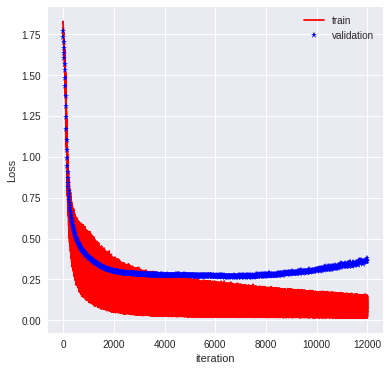

In [169]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

- Plot train and test accuracies

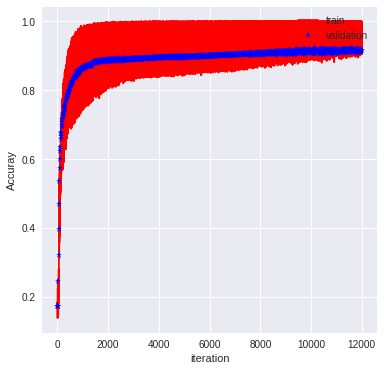

In [170]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

